In [2]:
%load_ext autoreload
%autoreload 2
import os
# Set environment variables
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".99"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import jax
# from jax import config
# config.update('jax_enable_x64', True)

# Check JAX configuration
devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())

import sys
# Add custom path
sys.path.append("/pchem-data/meuwly/boittier/home/pycharmm_test/src")

# from model import EF
# from loss import dipole_calc
# from  training import train_model # from model import dipole_calc
import jax
import optax
import e3x
import numpy as np

from physnetjax.models.model import EF
from physnetjax.training.loss import dipole_calc
from  physnetjax.training.training import train_model # from model import dipole_calc
from physnetjax.data.data import prepare_batches, prepare_datasets


import orbax
from orbax.checkpoint import PyTreeCheckpointer
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()

# from physnetjax.analysis import *

import polars as pl
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

from tensorflow.python.summary.summary_iterator import summary_iterator



import struct

def read_tensor(value):
    # Assuming the content is a single 32-bit float
    binary_content = value.tensor.tensor_content
    try:
        float_value = struct.unpack('f', binary_content)[0]  # 'f' is for 32-bit float
        # print(f"Decoded float value: {float_value}")
        return value.tag, float_value
    except struct.error:
        # print("Unable to decode binary content as float.")
         return value.tag, 0
    


def tensorboard_to_polars(logdir, i = 0):
    # Read the log file
    data = {}
    for event in summary_iterator(str(logdir)):
        for value in event.summary.value:
            k,v=read_tensor(value)
            data[k] = v
    data["epoch"] = i
    data["log"] = str(logdir)
    if data:
        df = pl.DataFrame(data)
        return df
    else:
        print("No scalar data found in the logdir.")
        return pl.DataFrame()

from pathlib import Path
from physnetjax.restart.restart import get_last, get_files, get_params_model
from physnetjax.analysis.analysis import plot_stats, count_params
import matplotlib.pyplot as plt
# restart_dir_base = Path("/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts")
# # Specify the log directory path
# path = restart_dir_base / "test-4ae608b9-b9f8-42e6-9292-4ff3841b9962/tfevents" 
# files = list(path.glob("*"))
# print(files[0])
# # Path to the TensorBoard log file
# log_file = str(files[0])

# # Convert TensorBoard logs to a Polars DataFrame
# base_df = pl.concat([tensorboard_to_polars(str(_),i=i) for i, _ in enumerate(files) ])

# # Display the first few rows
# print(base_df.head())
# print(base_df.columns)
DATA_FILES = ["/pchem-data/meuwly/boittier/home/jaxeq/notebooks/ala-esp-dip-0.npz"]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[CudaDevice(id=0)]
gpu
[CudaDevice(id=0)]


In [3]:
for l in [0,1,2]:
    for nres in [1,-1]:
        for feat in [32,64,128]:
            for nit in [2,4]:
                job = f"""sbatch --export=ALL,max_degree={l},nres={nres},num_iterations={nit},features={feat},data=/pchem-data/meuwly/boittier/home/jaxeq/notebooks/ala-esp-dip-0.npz,name=cf3all,natoms=37,totalchg=0.0,ntrain=8000,nvalid=1786,nepochs=50000,batch_size=8,schedule="constant" ./submit-job.sh
                """
                # print(job)
                # os.system(job)

In [4]:
for l in [0,]:
    for nres in [1]:
        for feat in [64]:
            for nit in [4]:
                job = f"""sbatch --export=ALL,max_degree={l},nres={nres},num_iterations={nit},features={feat},data=/pchem-data/meuwly/boittier/home/cf3criegee_27887.npz,name=cf3all,natoms=8,totalchg=0.0,ntrain=23887,nvalid=4000,nepochs=50000,batch_size=8,schedule="constant" ./submit-job.sh
                """
                print(job)
                # os.system(job)

sbatch --export=ALL,max_degree=0,nres=1,num_iterations=4,features=64,data=/pchem-data/meuwly/boittier/home/cf3criegee_27887.npz,name=cf3all,natoms=8,totalchg=0.0,ntrain=23887,nvalid=4000,nepochs=50000,batch_size=8,schedule="constant" ./submit-job.sh
                


In [5]:
# file_names = []
# ls = []
# fs = []
# nits = []
# for of in outfiles:
#     with open(of) as f:
#         lines = f.readlines(30000)
#         sel = [bytes(_, "utf8").decode("utf8") for _ in lines if "cf3all-" in _]
#         sel2 = [bytes(_, "utf8").decode("utf8") for _ in lines if "epoch" in _]
#         file_names.append("".join([sel[0].strip(),sel2[2].strip()]).strip())
#         l = [int(_.split("=")[-1].strip()) for _ in lines[:100] if _.startswith("    max_degree")]
#         f = [int(_.split("=")[-1].strip()) for _ in lines[:100] if _.startswith("    feat")]
#         nit = [int(_.split("=")[-1].strip()) for _ in lines[:100] if _.startswith("    num_i")]
#         ls.append(l)
#         fs.append(f)
#         nits.append(nit)

In [6]:
data_key, train_key = jax.random.split(
    jax.random.PRNGKey(43), 2)
# NATOMS = 8
# files = ["/pchem-data/meuwly/boittier/home/cf3criegee_27887.npz"]
NATOMS = 37
files = ["/pchem-data/meuwly/boittier/home/jaxeq/notebooks/ala-esp-dip-0.npz"]
train_data, valid_data = prepare_datasets(data_key, 8000, 1786,
                                          files, 
                                          clip_esp=False, natoms=NATOMS, clean=False)

2024-12-16 17:06:51.214878: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


shape (9786, 37, 3) not failed [   0    1    2 ... 9783 9784 9785]
dataR (9786, 37, 3)
D (9786, 3)
R (9786, 37, 3)
(9786, 37, 3)
['R', 'Z', 'F', 'E', 'N', 'D', 'com']
9786
0 R 9786 (9786, 37, 3)
1 Z 9786 (9786, 37)
2 F 9786 (9786, 37, 3)
3 E 9786 (9786, 1)
4 N 9786 (9786, 1)
5 D 9786 (9786, 3)
6 com 9786 (9786, 3)


In [7]:
ntest = len(valid_data["E"]) // 2
print(ntest)
test_data = {k: v[ntest:] for k, v in valid_data.items()}
valid_data = {k: v[:ntest] for k, v in valid_data.items()}


893


In [8]:
model = EF(
    # attributes
    features = 128,
    max_degree = 0,
    num_iterations = 5,
    num_basis_functions = 64,
    cutoff = 10.0,
    max_atomic_number = 12,
    charges = True,
    natoms=NATOMS,
    total_charge=0,
    n_res=4,
    zbl=True,
    # debug=["ele", "dist", "idx"],
)
model

EF(
    # attributes
    features = 128
    max_degree = 0
    num_iterations = 5
    num_basis_functions = 64
    cutoff = 10.0
    max_atomic_number = 12
    charges = True
    natoms = 37
    total_charge = 0
    n_res = 4
    zbl = True
    debug = False
)

In [9]:
import pandas as pd


data_keys = ("R", "Z", "F", "E", "D", "N", "dst_idx", "src_idx", "batch_segments")

batch_size = 2000
batch_size = 47

test_batches = prepare_batches(data_key, test_data, batch_size,
                              num_atoms=NATOMS, 
                              data_keys=data_keys)

train_batches = prepare_batches(data_key, train_data, batch_size,
                              num_atoms=NATOMS, 
                              data_keys=data_keys)

valid_batches = prepare_batches(data_key, valid_data, batch_size,
                              num_atoms=NATOMS, 
                              data_keys=data_keys)

combined = test_batches #+ valid_batches #+ train_batches
len(combined)

19

In [10]:
restart_dirs = ["cf3all-d069b2ca-0c5a-4fcd-b597-f8b28933693a",
"cf3all-a54b1970-25ee-4e9e-99d2-f76ae85cee6b",
"cf3all-8fa877e8-b561-47b7-9bcb-e23ad24371dc",
"cf3all-a9732697-ef01-4a54-812d-0456a2005076",
"cf3all-e94f959c-5f22-4b8a-800e-dd6197c07b20",
"cf3all-caf3d3d3-2a41-4737-af5e-233e2b5253a3",
"cf3all-05f0b23f-a6ca-455e-aeee-398d3ae6ff3d",
"cf3all-88eb2a0f-0dff-42a4-ab9d-621708453ff0",
"cf3all-eb18a03d-566e-4754-bcd0-7072998258df",
"cf3all-9fa0c7f2-dbff-4fbd-8f5c-12c8783816ae",
"cf3all-ecbb2297-d619-4bcf-9607-df23dfbce0dc",
"cf3all-ba34e2a6-090d-4ce7-9157-9ebcb492126c",
"cf3all-d74dfdc6-9673-4d47-98d4-361df28325f2",
"cf3all-18308861-b060-4b42-9a74-cb7504854a31",
"cf3all-560de4a4-3aa1-4822-8323-ab81b99f670e",
"cf3all-a9319d68-79aa-4913-98fe-2b09124fa1c8",
"cf3all-c0aca3a8-2a60-4480-b4c4-3c4ac076cc3e",
"cf3all-e8f16968-8b64-467b-a772-54d3594d516b",
"cf3all-1407135e-8deb-4cf6-a844-e0cc2bb44959",
"cf3all-08581d62-6dd2-4e78-a5b2-45cf6a4b6998",
"cf3all-cf8defb3-4024-4945-8eea-c7ed08320d04",
"cf3all-08a41d2b-b8f1-4a52-89ab-e0e3991a9b80",
"cf3all-ab54bbb8-1d99-4852-90f0-be5de65b1e0f",
"cf3all-948ae050-aeb3-47c2-9d55-7feed5b0a457",
"cf3all-11a2f3ed-8f24-42f6-9826-e771bbcda48c",
"cf3all-790736d2-59d2-4e61-9f61-2adbc68adf89",
"cf3all-de829b95-6df7-40aa-8095-89d63908ac50",
"cf3all-a45b7f73-3c7d-41c5-96e0-f0a83889293a",
"cf3all-3f0b4338-3dc7-4006-be1f-39255bd8003a",
"cf3all-893efd80-8eb6-4386-ad09-c3e8fa5c97ec",
"cf3all-b8b88599-315a-425a-adfd-8807e351f9c2",
"cf3all-071ebbc2-85b2-4ee6-93bb-4e4452726874",
"cf3all-272ee1d9-6570-4e22-b821-2ac104a822f2",
"cf3all-8c68a176-8a3f-442b-b68d-ba46b51fb335"]
CKPTPWD = Path("/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/")
restart_dirs = [CKPTPWD / _ for _ in restart_dirs]

In [11]:
# epochs_reached = []

# for restart_dir in restart_dirs:
#     restart = get_last(restart_dir)
#     print(restart.name)
#     epochs_reached.append(restart.name)

# epochs_reached.sort(key=lambda x: int(x.split("-")[1]))
# min_epoch = epochs_reached[0]
# min_epoch


In [12]:

for res in restart_dirs:
    job = f"""sbatch --export=ALL,restart={res},data=/pchem-data/meuwly/boittier/home/cf3criegee_27887.npz,name=cf3all,natoms=8,totalchg=0.0,ntrain=23887,nvalid=4000,nepochs=50000,batch_size=50,forces_w=1.0,schedule="warmup" ./submit-job.sh"""
    # os.system(job)

/pchem-data/meuwly/boittier/home/miniforge3/envs/jaxphyscharmm/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


dict_keys(['opt_state', 'params', 'step'])
EF(
    # attributes
    features = 128
    max_degree = 1
    num_iterations = 2
    num_basis_functions = 20
    cutoff = 10.0
    max_atomic_number = 9
    charges = True
    natoms = None
    total_charge = '0.0'
    n_res = 1
    zbl = False
    debug = False
)


1it [00:13, 13.97s/it]

predF.shape (5217,)


2it [00:14,  6.21s/it]

predF.shape (5217,)


3it [00:15,  3.73s/it]

predF.shape (5217,)


4it [00:16,  2.56s/it]

predF.shape (5217,)


5it [00:17,  1.91s/it]

predF.shape (5217,)


6it [00:17,  1.52s/it]

predF.shape (5217,)


7it [00:18,  1.28s/it]

predF.shape (5217,)


8it [00:19,  1.12s/it]

predF.shape (5217,)


9it [00:20,  1.01s/it]

predF.shape (5217,)


10it [00:20,  1.07it/s]

predF.shape (5217,)


11it [00:21,  1.13it/s]

predF.shape (5217,)


12it [00:22,  1.18it/s]

predF.shape (5217,)


13it [00:23,  1.22it/s]

predF.shape (5217,)


14it [00:23,  1.24it/s]

predF.shape (5217,)


15it [00:24,  1.26it/s]

predF.shape (5217,)


16it [00:25,  1.27it/s]

predF.shape (5217,)


17it [00:26,  1.28it/s]

predF.shape (5217,)


18it [00:27,  1.29it/s]

predF.shape (5217,)


19it [00:27,  1.46s/it]

predF.shape (5217,)


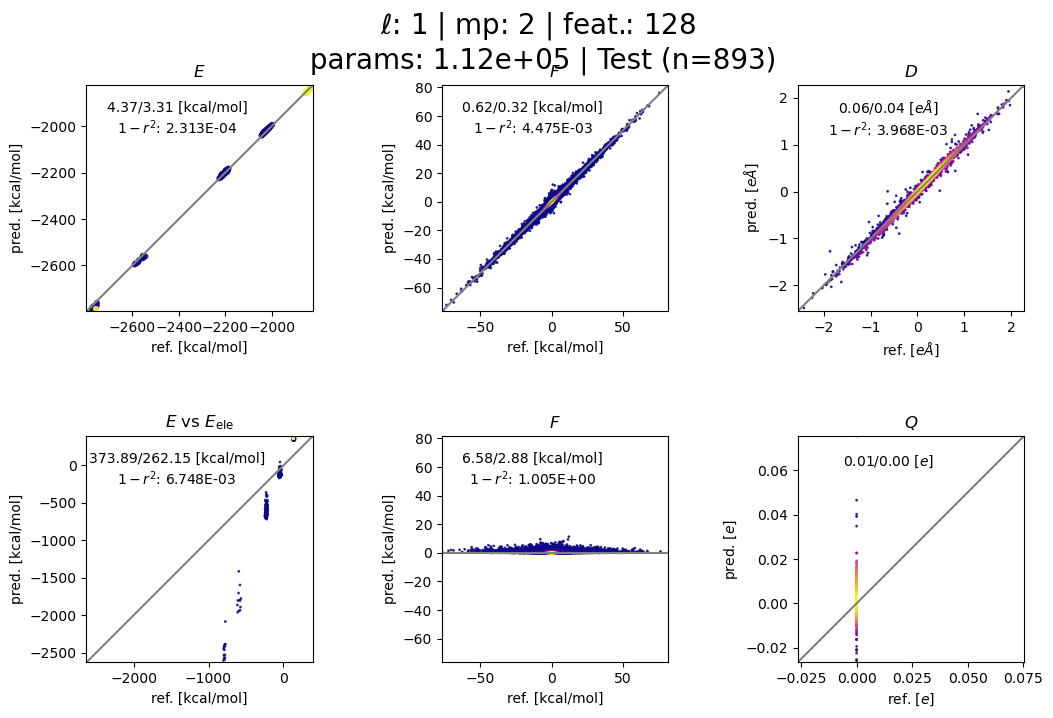

/pchem-data/meuwly/boittier/home/miniforge3/envs/jaxphyscharmm/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


dict_keys(['opt_state', 'params', 'step'])
EF(
    # attributes
    features = 128
    max_degree = 0
    num_iterations = 2
    num_basis_functions = 20
    cutoff = 10.0
    max_atomic_number = 9
    charges = True
    natoms = None
    total_charge = '0.0'
    n_res = 1
    zbl = False
    debug = False
)


1it [00:02,  2.22s/it]

predF.shape (5217,)


2it [00:02,  1.29s/it]

predF.shape (5217,)


3it [00:03,  1.01it/s]

predF.shape (5217,)


4it [00:04,  1.17it/s]

predF.shape (5217,)


5it [00:04,  1.29it/s]

predF.shape (5217,)


6it [00:05,  1.37it/s]

predF.shape (5217,)


7it [00:06,  1.43it/s]

predF.shape (5217,)


8it [00:06,  1.47it/s]

predF.shape (5217,)


9it [00:07,  1.50it/s]

predF.shape (5217,)


10it [00:07,  1.52it/s]

predF.shape (5217,)


11it [00:08,  1.53it/s]

predF.shape (5217,)


12it [00:09,  1.54it/s]

predF.shape (5217,)


13it [00:09,  1.55it/s]

predF.shape (5217,)


14it [00:10,  1.56it/s]

predF.shape (5217,)


15it [00:11,  1.56it/s]

predF.shape (5217,)


16it [00:11,  1.56it/s]

predF.shape (5217,)


17it [00:12,  1.56it/s]

predF.shape (5217,)


18it [00:13,  1.57it/s]

predF.shape (5217,)


19it [00:13,  1.39it/s]

predF.shape (5217,)


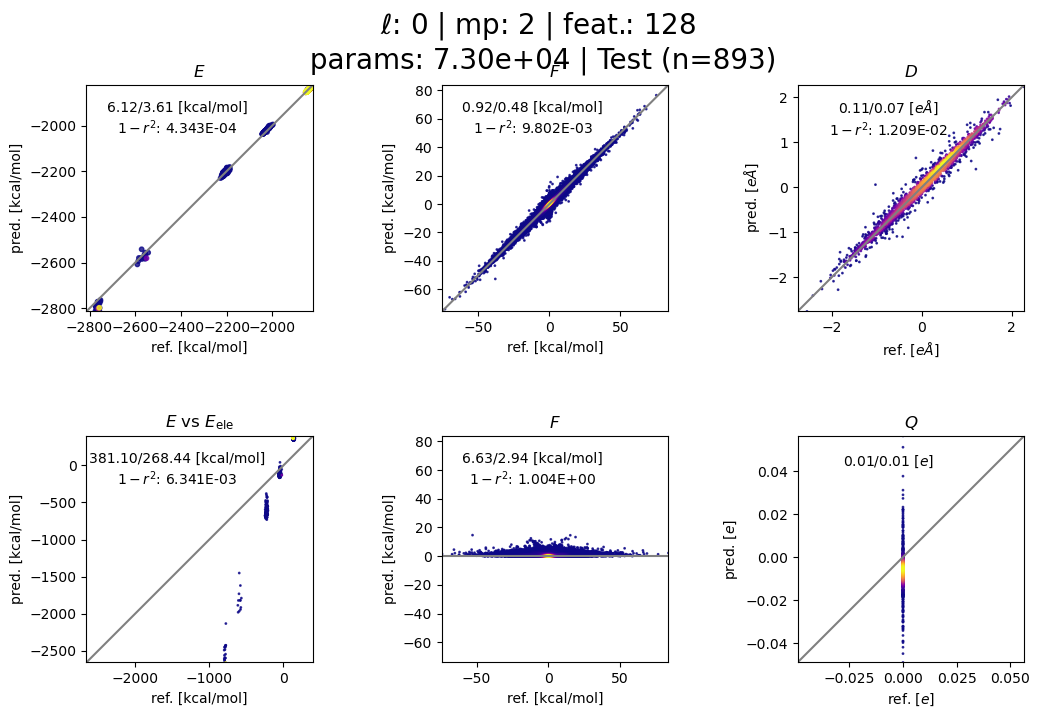

/pchem-data/meuwly/boittier/home/miniforge3/envs/jaxphyscharmm/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


dict_keys(['opt_state', 'params', 'step'])
EF(
    # attributes
    features = 32
    max_degree = 1
    num_iterations = 2
    num_basis_functions = 20
    cutoff = 10.0
    max_atomic_number = 9
    charges = True
    natoms = None
    total_charge = '0.0'
    n_res = 1
    zbl = False
    debug = False
)


1it [00:03,  3.73s/it]

predF.shape (5217,)


2it [00:04,  2.00s/it]

predF.shape (5217,)


3it [00:05,  1.45s/it]

predF.shape (5217,)


4it [00:06,  1.18s/it]

predF.shape (5217,)


5it [00:06,  1.03s/it]

predF.shape (5217,)


6it [00:07,  1.06it/s]

predF.shape (5217,)


7it [00:08,  1.00it/s]

predF.shape (5217,)


8it [00:09,  1.08it/s]

predF.shape (5217,)


9it [00:10,  1.12it/s]

predF.shape (5217,)


10it [00:11,  1.16it/s]

predF.shape (5217,)


11it [00:11,  1.19it/s]

predF.shape (5217,)


12it [00:12,  1.20it/s]

predF.shape (5217,)


13it [00:13,  1.21it/s]

predF.shape (5217,)


14it [00:14,  1.21it/s]

predF.shape (5217,)


15it [00:15,  1.21it/s]

predF.shape (5217,)


16it [00:15,  1.23it/s]

predF.shape (5217,)


17it [00:16,  1.24it/s]

predF.shape (5217,)


18it [00:17,  1.25it/s]

predF.shape (5217,)


19it [00:18,  1.04it/s]

predF.shape (5217,)


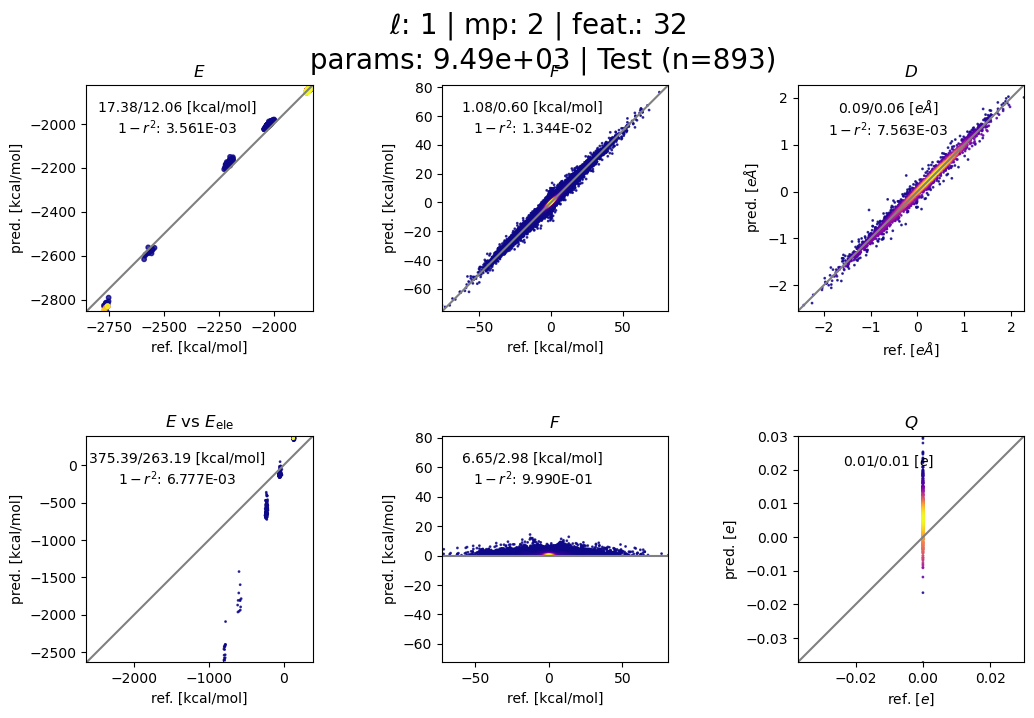

/pchem-data/meuwly/boittier/home/miniforge3/envs/jaxphyscharmm/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


dict_keys(['opt_state', 'params', 'step'])
EF(
    # attributes
    features = 64
    max_degree = 0
    num_iterations = 4
    num_basis_functions = 20
    cutoff = 10.0
    max_atomic_number = 9
    charges = True
    natoms = None
    total_charge = '0.0'
    n_res = 1
    zbl = False
    debug = False
)


1it [00:02,  2.34s/it]

predF.shape (5217,)


2it [00:03,  1.61s/it]

predF.shape (5217,)


3it [00:04,  1.38s/it]

predF.shape (5217,)


4it [00:05,  1.27s/it]

predF.shape (5217,)


5it [00:06,  1.21s/it]

predF.shape (5217,)


6it [00:07,  1.17s/it]

predF.shape (5217,)


7it [00:08,  1.15s/it]

predF.shape (5217,)


8it [00:10,  1.13s/it]

predF.shape (5217,)


9it [00:11,  1.12s/it]

predF.shape (5217,)


10it [00:12,  1.12s/it]

predF.shape (5217,)


11it [00:13,  1.12s/it]

predF.shape (5217,)


12it [00:14,  1.11s/it]

predF.shape (5217,)


13it [00:15,  1.11s/it]

predF.shape (5217,)


14it [00:16,  1.11s/it]

predF.shape (5217,)


15it [00:17,  1.10s/it]

predF.shape (5217,)


16it [00:18,  1.10s/it]

predF.shape (5217,)


17it [00:19,  1.10s/it]

predF.shape (5217,)


18it [00:21,  1.10s/it]

predF.shape (5217,)


19it [00:22,  1.17s/it]

predF.shape (5217,)


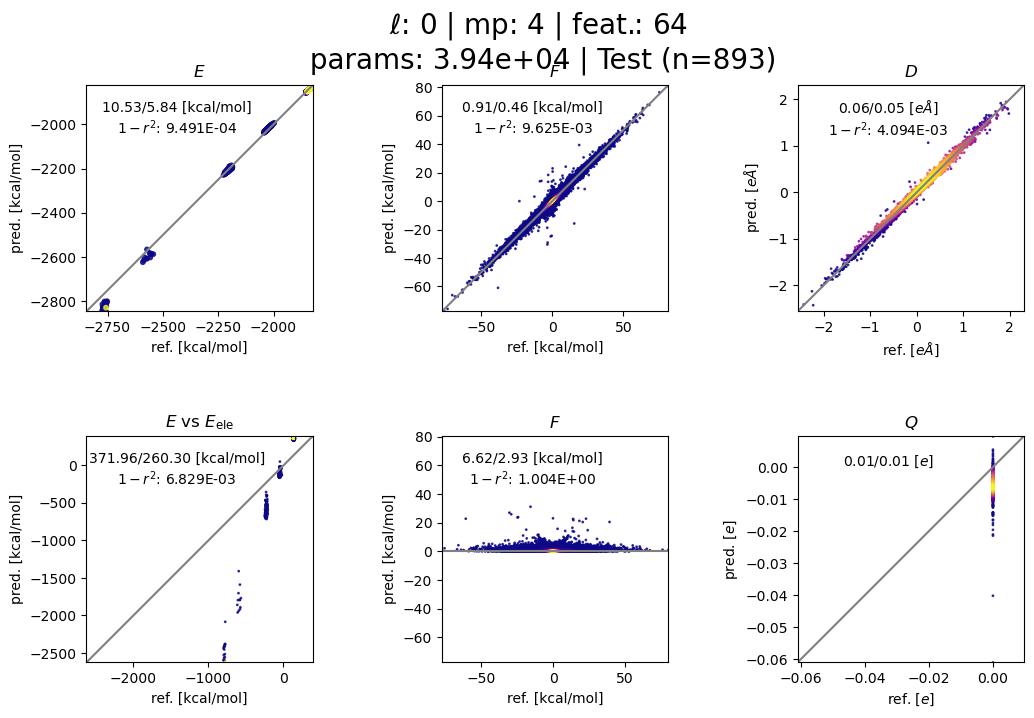

In [13]:

outputs = []
do_plot = True

for restart_dir in restart_dirs[:4]:
    # restart = restart_dir / min_epoch
    # _ = list(restart_dir.glob("epoch*"))
    # _.sort(key=lambda x: abs(int(str(x.name).split("-")[1])   - int(min_epoch.split("-")[1])))
    # restart = _[0]
    restart = get_last(restart_dir)
    params,model = get_params_model(restart)
    print(model)
    model.natoms = 37
    model.zbl = False
    total_params = count_params(params)
    # print("Total number of parameters:", total_params)
    output = plot_stats(combined, model, params, _set=f"$\\ell$: {model.max_degree} | mp: {model.num_iterations} | feat.: {model.features} \n params: {total_params:.2e} | Test", 
                   do_kde=True, batch_size=batch_size, do_plot=do_plot)
    if do_plot:
        plt.savefig(f"analysis/{str(restart_dir.name)}_test.pdf", bbox_inches="tight")
        plt.show()
    outputs.append(output)


In [14]:
keys_to_compare = ['E_rmse',
 'E_mae',
 'F_rmse',
 'F_mae',
 'D_rmse',
 'D_mae',
 'n_params',
 'features',
 'max_degree',
 'num_iterations',
 'num_basis_functions',
 'cutoff',
 'max_atomic_number',
 'natoms',
 'total_charge',
 'n_res']

In [15]:
results_df = pl.concat([pl.DataFrame({k:v for k,v in _.items() if k in keys_to_compare}, strict=False) for _ in outputs])
results_df = results_df.sort("n_params")
results_df = results_df.with_columns((52.91772105638412*pl.col("F_rmse") + pl.col("E_rmse") + 27.211386024367243*pl.col("D_rmse")).alias("combined_rmse"))


In [16]:
import seaborn as sns
sns.set_palette("crest")
# sns.color_palette("Spectral", as_cmap=True)

In [19]:
from physnetjax.logger.tensorboard_interface import process_tensorboard_logs
from physnetjax.analysis.plot_run import  plot_run
import polars as pl

In [20]:
results_df.sort("max_degree")

E_rmse,E_mae,F_rmse,F_mae,D_rmse,D_mae,n_params,features,max_degree,num_iterations,num_basis_functions,cutoff,max_atomic_number,natoms,total_charge,n_res,combined_rmse
f32,f32,f32,f32,f32,f32,i64,i64,i64,i64,i64,f64,i64,i64,str,i64,f32
10.531588,5.841214,0.909876,0.458291,0.064112,0.048106,39446,64,0,4,20,10.0,9,37,"""0.0""",1,60.424698
6.116586,3.610035,0.919039,0.480826,0.109787,0.074053,72982,128,0,2,20,10.0,9,37,"""0.0""",1,57.737499
17.377415,12.06191,1.076097,0.596642,0.087761,0.061173,9494,32,1,2,20,10.0,9,37,"""0.0""",1,76.710091
4.366898,3.310445,0.620426,0.319801,0.06453,0.04183,111638,128,1,2,20,10.0,9,37,"""0.0""",1,38.954391


In [21]:
# Faster than is_pareto_efficient_simple, but less readable.
def is_pareto_efficient(costs, return_mask = True):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :param return_mask: True to return a mask
    :return: An array of indices of pareto-efficient points.
        If return_mask is True, this will be an (n_points, ) boolean array
        Otherwise it will be a (n_efficient_points, ) integer array of indices.
    """
    is_efficient = np.arange(costs.shape[0])
    n_points = costs.shape[0]
    next_point_index = 0  # Next index in the is_efficient array to search for
    while next_point_index<len(costs):
        nondominated_point_mask = np.any(costs<costs[next_point_index], axis=1)
        nondominated_point_mask[next_point_index] = True
        is_efficient = is_efficient[nondominated_point_mask]  # Remove dominated points
        costs = costs[nondominated_point_mask]
        next_point_index = np.sum(nondominated_point_mask[:next_point_index])+1
    if return_mask:
        is_efficient_mask = np.zeros(n_points, dtype = bool)
        is_efficient_mask[is_efficient] = True
        return is_efficient_mask
    else:
        return is_efficient

def get_pareto_front(keys):
    costs = np.array(results_df[keys])
    pareto_front = is_pareto_efficient(costs)
    return pareto_front


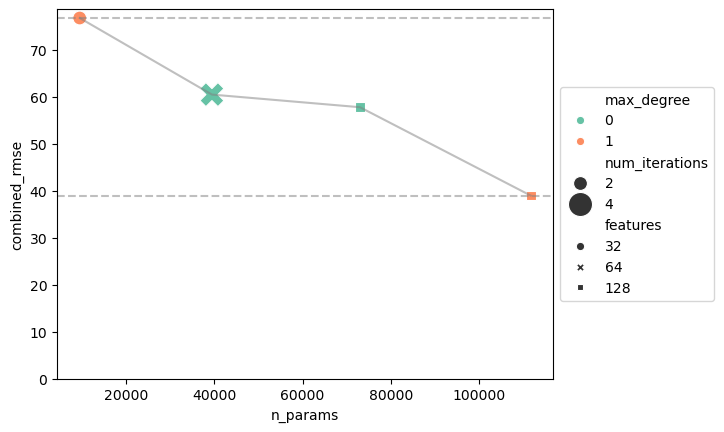

In [22]:
for i, ycol in enumerate(["combined_rmse"]):
    sns.scatterplot(results_df, x="n_params", y=ycol, hue="max_degree", style="features", size="num_iterations", 
                 # markers=[m[i] for _ in range(2)]
                    palette="Set2", sizes=(100, 300)
                )

keys = ["n_params", "combined_rmse"]
front = get_pareto_front(keys)
plt.plot(np.array(results_df["n_params"])[front], np.array(results_df["combined_rmse"])[front], color="gray", alpha=0.5)
plt.axhline(np.array(results_df["combined_rmse"])[front].min(), color="gray", alpha=0.5, linestyle="--")
plt.axhline(np.array(results_df["combined_rmse"])[front].max(), color="gray", alpha=0.5, linestyle="--")
plt.ylim(0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

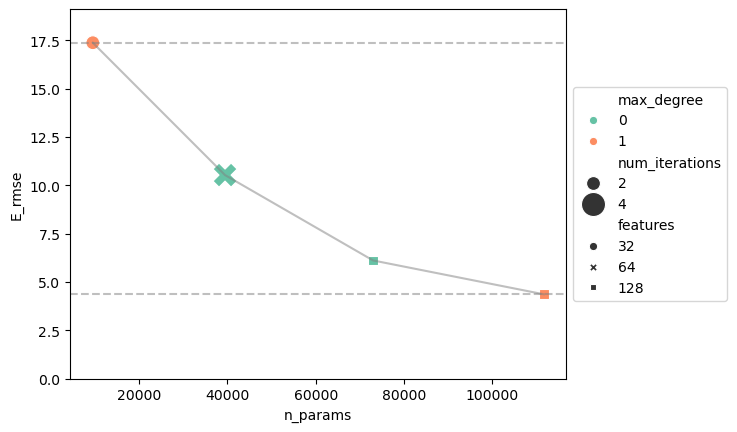

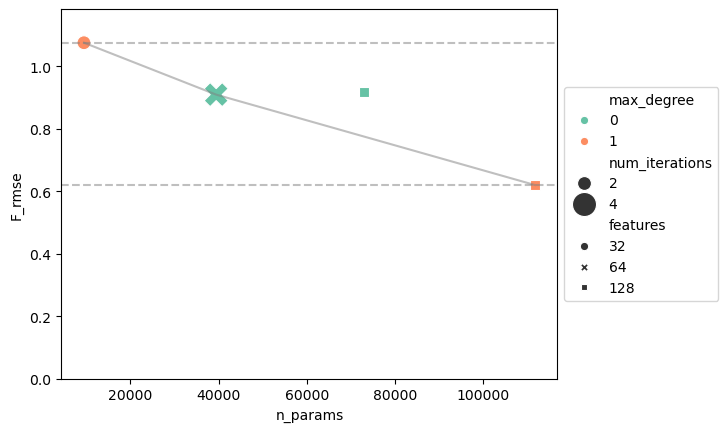

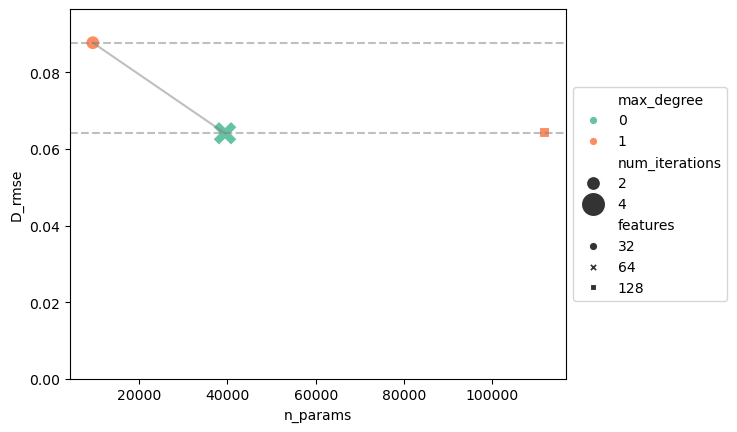

In [23]:
for i, ycol in enumerate(["E_rmse"]):
    sns.scatterplot(results_df, x="n_params", y=ycol, hue="max_degree", style="features", size="num_iterations", 
                 # markers=[m[i] for _ in range(2)]
                    palette="Set2", sizes=(100, 300)
                )
plt.ylim(0, np.array(results_df["E_rmse"])[front].max()*1.1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
keys = ["n_params", "E_rmse"]
front = get_pareto_front(keys)
plt.plot(np.array(results_df["n_params"])[front], np.array(results_df["E_rmse"])[front], color="gray", alpha=0.5)
plt.axhline(np.array(results_df["E_rmse"])[front].min(), color="gray", alpha=0.5, linestyle="--")
plt.axhline(np.array(results_df["E_rmse"])[front].max(), color="gray", alpha=0.5, linestyle="--")
plt.show()

for i, ycol in enumerate(["F_rmse"]):
    sns.scatterplot(results_df, x="n_params", y=ycol, hue="max_degree", style="features", size="num_iterations", 
                 # markers=[m[i] for _ in range(2)]
                    palette="Set2", sizes=(100, 300)
                )
plt.ylim(0, np.array(results_df["F_rmse"])[front].max()*1.1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
keys = ["n_params", "F_rmse"]
front = get_pareto_front(keys)
plt.plot(np.array(results_df["n_params"])[front], np.array(results_df["F_rmse"])[front], color="gray", alpha=0.5)
plt.axhline(np.array(results_df["F_rmse"])[front].min(), color="gray", alpha=0.5, linestyle="--")
plt.axhline(np.array(results_df["F_rmse"])[front].max(), color="gray", alpha=0.5, linestyle="--")
plt.show()


for i, ycol in enumerate(["D_rmse"]):
    sns.scatterplot(results_df, x="n_params", y=ycol, hue="max_degree", style="features", size="num_iterations", 
                 # markers=[m[i] for _ in range(2)]
                    palette="Set2", sizes=(100, 300)
                )
plt.ylim(0, np.array(results_df["D_rmse"])[front].max()*1.1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
keys = ["n_params", "D_rmse"]
front = get_pareto_front(keys)
plt.axhline(np.array(results_df["D_rmse"])[front].min(), color="gray", alpha=0.5, linestyle="--")
plt.axhline(np.array(results_df["D_rmse"])[front].max(), color="gray", alpha=0.5, linestyle="--")
plt.plot(np.array(results_df["n_params"])[front], np.array(results_df["D_rmse"])[front], color="gray", alpha=0.5)
plt.show()




In [ ]:
file_names = restart_dirs
dfs = [process_tensorboard_logs(Path(str(f).split("epoch-")[0] + "/tfevents/")) for f in file_names]
file_names
dfs

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [ ]:
new_dfs = []
for i in range(len(file_names)):
    _ = dfs[i].with_columns(
        pl.col("epoch")
        # .map_elements(lambda x: 0, return_dtype=pl.Int64)
        .map_elements(lambda x: ls[i][0], return_dtype=pl.Int64)
        .alias("l")
    )
    _ = _.with_columns(pl.col("epoch").map_elements(lambda x: nits[i][0], return_dtype=pl.Int64).alias("nit"))
    # _ = _.with_columns(pl.col("epoch").map_elements(lambda x: 0, return_dtype=pl.Int64).alias("nit"))
    new_dfs.append(_.with_columns(
    pl.col("epoch").map_elements(lambda x: fs[i][0], return_dtype=pl.Int64).alias("f")))
    # pl.col("epoch").map_elements(lambda x: i, return_dtype=pl.Int64).alias("f")))

    

In [ ]:
# new_dfs = pl.concat(new_dfs)
new_dfs = pl.concat(dfs)

# new_dfs = new_dfs.with_columns(
#     pl.col("log")
#     .map_elements(lambda x: x.split("/")[-3], return_dtype=pl.String)
#     .alias("uuid")
# )

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_run(base_df, ax, hue, label):
    base_df = base_df[::100]
    # base_df = base_df.to_pandas()
    # Define all the metrics to plot
    metrics = [
        "train_loss", "valid_loss", 
        "train_energy_mae", "valid_energy_mae", 
        "train_forces_mae", "valid_forces_mae", 
        "lr"
    ]
    

    
    # Plot each metric
    for i, ycol in enumerate(metrics):
        row = i % 2
        col = i // 2
        line = sns.lineplot(
            data=base_df, 
            x="epoch", y=ycol, 
            # hue=hue/33,
            color = sns.color_palette("Set2", 34)[hue],
            # style="f", size="nit", 
            ax=ax[row][col],
            # palette="set2", 
            label=label
            # legend=False 
        )
        ax[row][col].legend()
        lines, labels = [], []
            # Capture lines and labels for the shared legend
        for line_obj in line.get_lines():
            lines.append(line_obj)
        labels.append(i)
        
        # Apply shared settings
        # 
        # ax[row][col].set_xlim(1000)
        if ycol != "lr":
            ax[row][col].set_ylim(base_df[ycol].min()*0.5, base_df[ycol].median()+base_df[ycol].std())
            ax[row][col].set_yscale("log")
        ax[row][col].set_xlabel("Epoch")
        ax[row][col].set_ylabel(ycol)
        ax[row][col].get_legend().remove()  # Remove legend from the main plot
    
    # Adjust the legend on the separate axis
    handles, labels = ax[row][col].get_legend_handles_labels()
    ax[-1][-1].legend(
        handles=handles, labels=labels, 
        loc='center', title="Metrics"
    )
    ax[-1][-1].axis('off')  # Turn off axis for the legend space
    
    
    # plt.tight_layout()
    # plt.show()
    return ax


In [ ]:
# Set up the plot
fig, ax = plt.subplots(2,4,figsize=(20, 10))
for i, _ in enumerate(file_names[:]):
    if 21 <= i :
        print(i, _)
        ax = plot_run(dfs[i], ax, i, str(_).split("/")[-1])
plt.show()

In [490]:
import io
import ase
import ase.calculators.calculator as ase_calc
import ase.io as ase_io
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary, ZeroRotation
from ase.md.verlet import VelocityVerlet
import ase.optimize as ase_opt
import matplotlib.pyplot as plt
import py3Dmol


# Initialize atoms object and attach calculator.

d = train_data

sel = np.where(train_data['N'] == 37)[0]

i = sel[88]

print(d["Z"][i])
print(d['N'][i])
Natoms = d['N'][i][0] #32 #len(np.nonzero(R.sum(axis=1))[0])
print(Natoms)
model.natoms = Natoms
R = d['R'][i][:Natoms] # - np.mean(train_data['R'][i][:Natoms], axis=0)
print(R.sum(axis=1))
print(R)
print(d['Z'][i])
print("..", (np.nonzero(R.sum(axis=-1))[0].shape[0]))
#Natoms = np.nonzero(R.sum(axis=-1))[0].shape[0]
print(R.shape)
print(d["E"][i])



atoms = ase.Atoms(d['Z'][i][:Natoms], R[:Natoms] - R[:Natoms].mean(axis=0))
print(atoms)
res = "/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/cf3all-a45b7f73-3c7d-41c5-96e0-f0a83889293a"
restart = get_last(res)
params, model = get_params_model(restart)
print(model)
kwas = model.return_attributes()
print(kwas)
# model = EF(**kwas)
model.zbl = False
model.natoms = len(atoms)
# print(model)

@jax.jit
def evaluate_energies_and_forces(atomic_numbers, positions, dst_idx, src_idx):
  return model.apply(params,
    atomic_numbers=atomic_numbers,
    positions=positions,
    dst_idx=dst_idx,
    src_idx=src_idx,
  )


class MessagePassingCalculator(ase_calc.Calculator):
  implemented_properties = ["energy", "forces", "dipole"]

  def calculate(self, atoms, properties, system_changes = ase.calculators.calculator.all_changes):
    ase_calc.Calculator.calculate(self, atoms, properties, system_changes)
    dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(len(atoms))
    output = evaluate_energies_and_forces(
      atomic_numbers=atoms.get_atomic_numbers(),
      positions=atoms.get_positions(),
      dst_idx=dst_idx,
      src_idx=src_idx
    )

    dipole = dipole_calc(atoms.get_positions(), 
                         atoms.get_atomic_numbers(), 
                         output["charges"],
                np.zeros_like(atoms.get_atomic_numbers()),
                1)
    self.results["dipole"] = dipole
    self.results['energy'] = output["energy"].squeeze() #* (ase.units.kcal/ase.units.mol)
    self.results['forces'] = output["forces"] #* (ase.units.kcal/ase.units.mol) #/ase.units.Angstrom

[6 1 1 1 6 8 7 1 6 1 6 1 1 1 6 8 7 1 6 1 1 1 8 1 1 8 1 1 8 1 1 8 1 1 8 1 1]
[37]
37
[-10.60972454  -8.91284632 -10.75600094 -10.75064754 -12.62640969
 -14.42914659 -12.4296276  -13.85759213 -10.46808926 -11.04512067
  -9.78875204 -11.37131422  -8.76544652  -8.79123205  -8.41094191
  -8.60012416  -6.40409171  -6.42884124  -4.34666742  -4.81860763
  -3.25319195  -3.35101267  -2.1134388   -3.04457047  -3.125377
 -16.31502851 -17.05119604 -17.35928308  -3.51694006  -2.26775753
  -2.81186151  -5.15616335  -5.71594382  -6.50864336  -8.36671987
  -8.55412577  -6.73636034]
[[-10.25765     -1.50426703   1.15219249]
 [ -9.49653753  -0.73478755   1.31847876]
 [ -9.93465901  -2.43967385   1.61833192]
 [-11.19423873  -1.18565064   1.62924183]
 [-10.51842363  -1.79703012  -0.31095595]
 [-10.82338497  -2.92039011  -0.68537151]
 [-10.46087034  -0.76648976  -1.2022675 ]
 [-10.63777308  -1.06652738  -2.15329168]
 [-10.09086377   0.61685561  -0.9940811 ]
 [-10.13118364   1.07761042  -1.99154744]
 [-11.07

/pchem-data/meuwly/boittier/home/miniforge3/envs/jaxphyscharmm/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


dict_keys(['opt_state', 'params', 'step'])
EF(
    # attributes
    features = 128
    max_degree = 1
    num_iterations = 4
    num_basis_functions = 20
    cutoff = 10.0
    max_atomic_number = 9
    charges = True
    natoms = None
    total_charge = '0.0'
    n_res = 1
    zbl = False
    debug = False
)
{'features': 128, 'max_degree': 1, 'num_iterations': 4, 'num_basis_functions': 20, 'cutoff': 10.0, 'max_atomic_number': 9, 'charges': True, 'natoms': None, 'total_charge': '0.0', 'n_res': 1}


In [491]:

atoms.set_calculator(MessagePassingCalculator())

# Write structure to xyz file.
xyz = io.StringIO()
ase_io.write(xyz, atoms, format='xyz')

# Visualize the structure with py3Dmol.
view = py3Dmol.view()
view.addModel(xyz.getvalue(), 'xyz')
view.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.25}})
view.show()



/tmp/ipykernel_122020/4040092950.py:1: DeprecationWarning: Please use atoms.calc = calc
  atoms.set_calculator(MessagePassingCalculator())


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [492]:
# Run structure optimization with BFGS.
_ = ase_opt.LBFGS(atoms).run(fmax=0.001,steps=1000)
print()

       Step     Time          Energy          fmax
LBFGS:    0 23:45:19     -121.126297        0.215310
LBFGS:    1 23:45:19     -121.131279        0.185762
LBFGS:    2 23:45:19     -121.138794        0.211357
LBFGS:    3 23:45:19     -121.153915        0.420821
LBFGS:    4 23:45:19     -121.164352        0.298255
LBFGS:    5 23:45:19     -121.175423        0.210807
LBFGS:    6 23:45:19     -121.186646        0.214288
LBFGS:    7 23:45:19     -121.199585        0.299344
LBFGS:    8 23:45:19     -121.212631        0.322154
LBFGS:    9 23:45:19     -121.223625        0.219018
LBFGS:   10 23:45:19     -121.232796        0.206202
LBFGS:   11 23:45:19     -121.244850        0.221663
LBFGS:   12 23:45:19     -121.258568        0.367441
LBFGS:   13 23:45:19     -121.271591        0.318588
LBFGS:   14 23:45:19     -121.279427        0.224386
LBFGS:   15 23:45:19     -121.284821        0.213086
LBFGS:   16 23:45:19     -121.293297        0.253667
LBFGS:   17 23:45:19     -121.306198        0.30

In [493]:
print(atoms.get_dipole_moment())
# Write structure to xyz file.
xyz = io.StringIO()
ase_io.write(xyz, atoms, format='xyz')
# Visualize the structure with py3Dmol.
view = py3Dmol.view()
view.addModel(xyz.getvalue(), 'xyz')
view.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.25}})
view.show()

[[1.7872174  0.70209897 0.49025187]]


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [494]:
# Parameters.
temperature = 300.0
timestep_fs = 0.1
num_steps = 100_0

# Draw initial momenta.
MaxwellBoltzmannDistribution(atoms, temperature_K=temperature)
Stationary(atoms)  # Remove center of mass translation.
ZeroRotation(atoms)  # Remove rotations.

# Initialize Velocity Verlet integrator.
integrator = VelocityVerlet(atoms, timestep=timestep_fs*ase.units.fs)

# Run molecular dynamics.
frames = np.zeros((num_steps, len(atoms), 3))
dipoles = np.zeros((num_steps, 1, 3))
potential_energy = np.zeros((num_steps,))
kinetic_energy = np.zeros((num_steps,))
total_energy = np.zeros((num_steps,))
for i in range(num_steps):
  # Run 1 time step.
  integrator.run(1)
  # Save current frame and keep track of energies.
  frames[i] = atoms.get_positions()
  potential_energy[i] = atoms.get_potential_energy()
  kinetic_energy[i] = atoms.get_kinetic_energy()
  total_energy[i] = atoms.get_total_energy()
  dipoles[i]=atoms.get_dipole_moment()
  # Occasionally print progress.q
  if i % 1000 == 0:
    print(f"step {i:5d} epot {potential_energy[i]: 5.3f} ekin {kinetic_energy[i]: 5.3f} etot {total_energy[i]: 5.3f}")
    MaxwellBoltzmannDistribution(atoms, temperature_K=temperature)

step     0 epot -130.417 ekin  1.544 etot -128.873


In [495]:
view.getModel().setCoordinates(frames[::10], 'array')
view.animate({'loop': None, 'interval': 0.1})
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
%matplotlib inline
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.xlabel('time [fs]')
plt.ylabel('energy [eV]')
time = np.arange(num_steps) * timestep_fs
plt.plot(time, potential_energy, label='potential energy')
plt.legend()
plt.grid()
plt.show()
plt.plot(time, kinetic_energy, label='kinetic energy')
plt.legend()
plt.grid()
plt.show()
plt.plot(time, total_energy - total_energy.mean(), label='total energy')
plt.legend()
plt.ylim(-23/1000, 23/1000)
plt.xlabel('time [fs]')
plt.ylabel('energy [eV]')
plt.grid()

In [ ]:
r = dipoles
# for i in range(3):

plt.plot(np.linalg.norm(r,axis=-1))

In [ ]:
from physnetjax.ir import autocorrelation_ft, intensity_correction, rolling_avg
temm =total_energy - total_energy.mean()
total_E_stack = np.stack([temm, temm, temm]).T

freq, spectra = autocorrelation_ft(total_E_stack, timestep_fs * 0.001 )
# freq, spectra = intensity_correction(freq, spectra, 1000000000000000)
freq, spectra = rolling_avg(freq, spectra)
total_E_stack.shape

In [ ]:
plt.plot(freq, spectra)
# plt.ylim(0,0.2)
plt.yscale("log")
plt.xlim(1, 4000)
# .shape, dipoles.shape

In [ ]:
from physnetjax.ir import autocorrelation_ft, intensity_correction, rolling_avg
freq, spectra = autocorrelation_ft(dipoles.squeeze(), timestep_fs * 0.001 )
freq, spectra = intensity_correction(freq, spectra, 1000000000000000)
freq, spectra = rolling_avg(freq, spectra, 2)

In [ ]:
from physnetjax.ir import autocorrelation_ft, intensity_correction, rolling_avg
freq, spectra = autocorrelation_ft(dipoles.squeeze(), timestep_fs * 0.001 )
freq, spectra = intensity_correction(freq, spectra, 1000000000000000)
freq, spectra = rolling_avg(freq, spectra)

In [ ]:
plt.plot(freq, spectra)
# plt.ylim(0,0.2)
plt.xlim(1, 4000)

In [ ]:
plt.plot(freq, spectra)
# plt.ylim(0,0.2)
plt.xlim(1, 4000)